In [220]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from os import mkdir
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from b2b_regression import *
import re
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mouse_utils import *
from cross_b2b_utils import *

In [2]:
mouse_struct = scipy.io.loadmat("Rule-switch experiment/Mouse_M01.mat")["mouse_struct"]
column_names = np.stack(([mouse_struct[i][0] for i in range(0, (len(mouse_struct)))]))
data_type = mouse_struct[0].dtype
column_names = np.asarray(data_type.names)

In [3]:
mice = ["01", "02", "03", "04", "05", "06"]

In [4]:
n_neurons = []
for mouse in mice:
    session_labels = ["T1", "T2", "T3", "T4", "T5",  "T6", "T7", "T8"]
    mouse_struct = scipy.io.loadmat("Rule-switch experiment/Mouse_M%s.mat" % mouse)["mouse_struct"]
    directoryExists = os.path.exists("Rule-switch experiment/csv/mouse%s" % mouse)
    if not directoryExists:
        mkdir("Rule-switch experiment/csv/mouse%s" % mouse)
    if mouse == "01" or mouse == "02":
        session_labels.remove("T3")
    elif mouse == "06":
        session_labels.remove("T7")
        session_labels.remove("T8")
    for session in session_labels:
        for i in range(len(mouse_struct[0][session_labels.index(session)])):
            if len(mouse_struct[0][session_labels.index(session)][i]) == 0:
                df = pd.DataFrame(columns = [column_names[i]])
                df.to_csv("Rule-switch experiment/csv/mouse%s/mouse%s_%s_%s.csv" % (mouse, mouse, session, column_names[i]))
            else:
                try:
                    df = pd.DataFrame(data = mouse_struct[0][session_labels.index(session)][i][0], columns = [column_names[i]])
                except Exception as e:
                    pass
                df["mouse"] = mouse
                df["session"] = session
                df.to_csv("Rule-switch experiment/csv/mouse%s/mouse%s_%s_%s.csv" % (mouse, mouse, session, column_names[i]))
        is_mouse_no_T3 = False
        neuron_id = np.empty([len(mouse_struct[0][session_labels.index(session)][7]),], dtype = "U2")
        neuron_id = ["n%s" % neuron for neuron in np.arange(len(mouse_struct[0][session_labels.index(session)][7]))]
        df = pd.DataFrame(data = mouse_struct[0][session_labels.index(session)][7].T, columns = neuron_id)
        if neuron_id not in n_neurons:
            n_neurons.append(neuron_id)
        df.to_csv("Rule-switch experiment/csv/mouse%s/mouse%s_%s_%s.csv" % (mouse, mouse, session,column_names[7]))

In [5]:
data_list_wide = []
data_list_long = []
i = 0
for mouse in mice:
    mouse_list = []
    for session in session_labels:
        try:
            df = pd.read_csv("Rule-switch experiment/csv/mouse%s/mouse%s_%s_CategoryID.csv" % (mouse, mouse, session)).iloc[:, 1:]
            for column in np.delete(column_names, [0,7, 8, 9, 10,11]):
                df_to_merge = pd.read_csv("Rule-switch experiment/csv/mouse%s/mouse%s_%s_%s.csv" % (mouse, mouse, session, column)).iloc[:, 1]
                df = pd.concat([df, df_to_merge], axis = 1)
            df_to_merge = pd.read_csv("Rule-switch experiment/csv/mouse%s/mouse%s_%s_%s.csv" % (mouse, mouse, session, column_names[7]))
            df_mouse_session = pd.concat([df, df_to_merge.iloc[:, 1:]], axis = 1)
            mouse_list.append(df_mouse_session)
        except FileNotFoundError as e:
            pass
    df_mouse_wide = pd.concat(mouse_list, axis = 0)
    data_list_wide.append(df_mouse_wide)
    df_mouse_long = df_mouse_wide.melt(id_vars=np.asarray(df.columns[:9]), value_vars =n_neurons[i], var_name = "Cell", value_name = "CellResponse", ignore_index= True)
    data_list_long.append(df_mouse_long)
    i = i + 1
data_wide = pd.concat(data_list_wide, axis = 0)
data_long = pd.concat(data_list_long, axis = 0)
data_long = data_long.rename(columns = {"stimulusSF":"StimulusSF"})
data_long["CategoryID"] = data_long["CategoryID"].replace(1, 0)
data_long["CategoryID"] = data_long["CategoryID"].replace(5, 1)

In [6]:
mice_diff_regions = ["07", "08", "09", "10", "11"]
session_labels = ["T1", "T2", "T3", "T4", "T5",  "T6", "T7", "T8"]
n_neurons_region1 = []
directoryExists = os.path.exists("Rule-switch experiment/csv/region1")
if not directoryExists:
    mkdir("Rule-switch experiment/csv/region1")
for mouse in mice_diff_regions:
    mouse_struct = scipy.io.loadmat("Rule-switch experiment/Mouse_M%s_Region1.mat" % mouse)["mouse_struct"]
    directoryExists = os.path.exists("Rule-switch experiment/csv/region1/mouse%s_region1" % mouse)
    if not directoryExists:
        mkdir("Rule-switch experiment/csv/region1/mouse%s_region1" % mouse)
    for session in session_labels:
        for i in range(len(mouse_struct[0][session_labels.index(session)])):
            if len(mouse_struct[0][session_labels.index(session)][i]) == 0:
                df = pd.DataFrame(columns = [column_names[i]])
                df.to_csv("Rule-switch experiment/csv/region1/mouse%s_region1/mouse%s_%s_%s_region1.csv" % (mouse, mouse, session, column_names[i]))
            else:
                try:
                    df = pd.DataFrame(data = mouse_struct[0][session_labels.index(session)][i][0], columns = [column_names[i]])
                except Exception as e:
                    pass
                df["mouse"] = mouse
                df["session"] = session
                df.to_csv("Rule-switch experiment/csv/region1/mouse%s_region1/mouse%s_%s_%s_region1.csv" % (mouse, mouse, session, column_names[i]))
        neuron_id = np.empty([len(mouse_struct[0][session_labels.index(session)][7]),], dtype = "U2")
        neuron_id = ["n%s" % neuron for neuron in np.arange(len(mouse_struct[0][session_labels.index(session)][7]))]
        df = pd.DataFrame(data = mouse_struct[0][session_labels.index(session)][7].T, columns = neuron_id)
        if neuron_id not in n_neurons_region1:
            n_neurons_region1.append(neuron_id)
        df.to_csv("Rule-switch experiment/csv/region1/mouse%s_region1/mouse%s_%s_%s_region1.csv" % (mouse, mouse, session,column_names[7]))

In [7]:
data_list_region1 = []
i = 0
for mouse in mice_diff_regions:
    mouse_list = []
    for session in session_labels:
        try:
            df = pd.read_csv("Rule-switch experiment/csv/region1/mouse%s_region1/mouse%s_%s_CategoryID_region1.csv" % (mouse, mouse, session)).iloc[:, 1:]
            for column in np.delete(column_names, [0,7, 8, 9, 10,11]):
                df_to_merge = pd.read_csv("Rule-switch experiment/csv/region1/mouse%s_region1/mouse%s_%s_%s_region1.csv" % (mouse, mouse, session, column)).iloc[:, 1]
                df = pd.concat([df, df_to_merge], axis = 1)
            df_to_merge = pd.read_csv("Rule-switch experiment/csv/region1/mouse%s_region1/mouse%s_%s_%s_region1.csv" % (mouse, mouse, session, column_names[7]))
            df_mouse_session = pd.concat([df, df_to_merge.iloc[:, 1:]], axis = 1)
            mouse_list.append(df_mouse_session)
        except FileNotFoundError as e:
            pass

    df_mouse = pd.concat(mouse_list, axis = 0)
    df_mouse = df_mouse.melt(id_vars=np.asarray(df.columns[:9]), value_vars =n_neurons_region1[i], var_name = "Cell", value_name = "CellResponse", ignore_index= True)
    data_list_region1.append(df_mouse)
    i = i + 1
data_region1 = pd.concat(data_list_region1, axis = 0)
data_region1 = data_region1.rename(columns = {"stimulusSF":"StimulusSF"})
data_region1["CategoryID"] = data_region1["CategoryID"].replace(1, 0)
data_region1["CategoryID"] = data_region1["CategoryID"].replace(5, 1)

In [8]:
n_neurons_region2 = []
directoryExists = os.path.exists("Rule-switch experiment/csv/region2")
if not directoryExists:
    mkdir("Rule-switch experiment/csv/region2")
for mouse in mice_diff_regions:
    mouse_struct = scipy.io.loadmat("Rule-switch experiment/Mouse_M%s_Region2.mat" % mouse)["mouse_struct"]
    directoryExists = os.path.exists("Rule-switch experiment/csv/region2/mouse%s_region2" % mouse)
    if not directoryExists:
        mkdir("Rule-switch experiment/csv/region2/mouse%s_region2" % mouse)
    for session in session_labels:
        for i in range(len(mouse_struct[0][session_labels.index(session)])):
            if len(mouse_struct[0][session_labels.index(session)][i]) == 0:
                df = pd.DataFrame(columns = [column_names[i]])
                df.to_csv("Rule-switch experiment/csv/region2/mouse%s_region2/mouse%s_%s_%s_region2.csv" % (mouse, mouse, session, column_names[i]))
            else:
                try:
                    df = pd.DataFrame(data = mouse_struct[0][session_labels.index(session)][i][0], columns = [column_names[i]])
                except Exception as e:
                    pass
                df["mouse"] = mouse
                df["session"] = session
                df.to_csv("Rule-switch experiment/csv/region2/mouse%s_region2/mouse%s_%s_%s_region2.csv" % (mouse, mouse, session, column_names[i]))
        neuron_id = np.empty([len(mouse_struct[0][session_labels.index(session)][7]),], dtype = "U2")
        neuron_id = ["n%s" % neuron for neuron in np.arange(len(mouse_struct[0][session_labels.index(session)][7]))]
        df = pd.DataFrame(data = mouse_struct[0][session_labels.index(session)][7].T, columns = neuron_id)
        if neuron_id not in n_neurons_region2:
            n_neurons_region2.append(neuron_id)
        df.to_csv("Rule-switch experiment/csv/region2/mouse%s_region2/mouse%s_%s_%s_region2.csv" % (mouse, mouse, session,column_names[7]))

In [9]:
data_list_region2 = []
i = 0
for mouse in mice_diff_regions:
    mouse_list = []
    for session in session_labels:
        try:
            df = pd.read_csv("Rule-switch experiment/csv/region2/mouse%s_region2/mouse%s_%s_CategoryID_region2.csv" % (mouse, mouse, session)).iloc[:, 1:]
            for column in np.delete(column_names, [0,7, 8, 9, 10,11]):
                df_to_merge = pd.read_csv("Rule-switch experiment/csv/region2/mouse%s_region2/mouse%s_%s_%s_region2.csv" % (mouse, mouse, session, column)).iloc[:, 1]
                df = pd.concat([df, df_to_merge], axis = 1)
            df_to_merge = pd.read_csv("Rule-switch experiment/csv/region2/mouse%s_region2/mouse%s_%s_%s_region2.csv" % (mouse, mouse, session, column_names[7]))
            df_mouse_session = pd.concat([df, df_to_merge.iloc[:, 1:]], axis = 1)
            mouse_list.append(df_mouse_session)
        except FileNotFoundError as e:
            pass
    df_mouse = pd.concat(mouse_list, axis = 0)
    df_mouse = df_mouse.melt(id_vars=np.asarray(df.columns[:9]), value_vars =n_neurons_region2[i], var_name = "Cell", value_name = "CellResponse", ignore_index= True)
    data_list_region2.append(df_mouse)
    i = i + 1
data_region2 = pd.concat(data_list_region2, axis = 0)
data_region2 = data_region2.rename(columns = {"stimulusSF":"StimulusSF"})
data_region2["CategoryID"] = data_region2["CategoryID"].replace(1, 0)
data_region2["CategoryID"] = data_region2["CategoryID"].replace(5, 1)

In [10]:
rules = {
            "1":"ORI",
            "2":"SF",
            "3":"SF",
            "4":"ORI",
            "5":"SF",
            "6":"SF"
        }

rules_region = {
            "7":"SF",
            "8":"ORI",
            "9":"ORI",
            "10":"SF",
            "11":"ORI",
        }

T5_regressors = ['CategoryID', 'GoChoice', 'Reward', 'StimulusSF_0.023',
       'StimulusSF_0.027', 'StimulusSF_0.033', 'StimulusSF_0.06',
       'StimulusSF_0.1', 'StimulusSF_0.25', 'StimulusORI_0',
       'StimulusORI_15', 'StimulusORI_30', 'StimulusORI_60',
       'StimulusORI_75', 'StimulusORI_90']

In [15]:
mice = [1, 2, 3, 4, 5, 6]
mice_regions = [7, 8, 9, 10, 11]

In [17]:
G_mice1_6 = []
G_mice7_11_region1 = []
G_mice7_11_region2 = []

for mouse in mice:
    G_ = np.load(os.getcwd() + "/b2b/G/true_G/G_mouse%s_T5.npy" % mouse)
    G_mice1_6.append(G_)

for mouse in mice_regions:
    G_ = np.load(os.getcwd() + "/b2b/G/true_G/G_mouse%s_region%s_T5.npy" % (mouse, 1))
    G_mice7_11_region1.append(G_)

for mouse in mice_regions:
    G_ = np.load(os.getcwd() + "/b2b/G/true_G/G_mouse%s_region%s_T5.npy" % (mouse, 2))
    G_mice7_11_region2.append(G_)

In [192]:
dummy_vars = ['StimulusSF', "StimulusORI"]

indep_vars_T1 = []
cell_resp_T1 = []
for mouse in mice:
    predictors, predictors_labels_T1_mice1_6 = make_predictors(data_long, mouse, session = "T1", dummify_vars= dummy_vars, cross_session_analysis= True, reference_labels= T5_regressors)
    cell_resp, nan_indices = get_cell_response(data_long, mouse, session = "T1")
    if nan_indices.any() != None:
        predictors = np.delete(predictors, obj = nan_indices, axis = 0)
    indep_vars_T1.append(predictors)
    cell_resp_T1.append(cell_resp)

indep_vars_region1_T1 = []
cell_resp_region1_T1 = []
for mouse in mice_regions:
    predictors, predictors_labels_T1_mice7_11_region1 = make_predictors(data_region1, mouse, session = "T1", dummify_vars= dummy_vars, cross_session_analysis= True, reference_labels= T5_regressors, region = 1)
    cell_resp, nan_indices = get_cell_response(data_region1, mouse, session = "T1")
    if nan_indices.any() != None:
        predictors = np.delete(predictors, obj = nan_indices, axis = 0)
    indep_vars_region1_T1.append(predictors)
    cell_resp_region1_T1.append(cell_resp)

indep_vars_region2_T1 = []
cell_resp_region2_T1 = []
for mouse in mice_regions:
    predictors, predictors_labels_T1_mice7_11_region2 = make_predictors(data_region2, mouse, session = "T1", dummify_vars= dummy_vars, cross_session_analysis= True, reference_labels= T5_regressors, region = 1)
    cell_resp, nan_indices = get_cell_response(data_region2, mouse, session = "T1")
    if nan_indices.any() != None:
        predictors = np.delete(predictors, obj = nan_indices, axis = 0)
    indep_vars_region2_T1.append(predictors)
    cell_resp_region2_T1.append(cell_resp)

In [193]:
data_long[(data_long["mouse"] == 1) & (data_long["session"] == "T1")]["StimulusORI"].unique()
data_long[(data_long["mouse"] == 1) & (data_long["session"] == "T1")]["StimulusSF"].unique()

array([15, 60,  0, 30, 90, 75])

array([0.033, 0.25 , 0.1  , 0.06 , 0.027, 0.023])

In [194]:
G_optim_mice1_6 = [remove_regressors_from_G(G, T5_regressors, predictors_labels_T1_mice1_6) for G in G_mice1_6]
G_optim_mice7_11_region1 = [remove_regressors_from_G(G, T5_regressors, predictors_labels_T1_mice7_11_region1) for G in G_mice7_11_region1]
G_optim_mice7_11_region2 = [remove_regressors_from_G(G, T5_regressors, predictors_labels_T1_mice7_11_region2) for G in G_mice7_11_region2]

In [198]:
G_optim_mice1_6[2].shape # (regs, cells)
indep_vars_T1[2].shape # (trials, regs)
cell_resp_T1[2].shape # (trials, cells)

(15, 134)

(191, 15)

(191, 134)

In [199]:
cross_H_mice1_6_T1 = [cross_fit_H(G, indep_vars, cell_resp)[1] for G, indep_vars, cell_resp in zip(G_optim_mice1_6, indep_vars_T1, cell_resp_T1)]
cross_H_mice7_11_region1_T1 = [cross_fit_H(G, indep_vars, cell_resp)[1] for G, indep_vars, cell_resp in zip(G_optim_mice7_11_region1, indep_vars_region1_T1, cell_resp_region1_T1)]
cross_H_mice7_11_region2_T1 = [cross_fit_H(G, indep_vars, cell_resp)[1] for G, indep_vars, cell_resp in zip(G_optim_mice7_11_region2, indep_vars_region2_T1, cell_resp_region2_T1)]

In [202]:
cross_deltaR_mice1_6_T1 = [get_cross_deltaR(G_optim_mice1_6[i], cross_H_mice1_6_T1[i], predictors_labels_T1_mice1_6, "T1", indep_vars_T1[i], cell_resp_T1[i]) for i in range(len(mice))]
cross_S_mice1_6_T1 = [get_cross_S(G_optim_mice1_6[i], predictors_labels_T1_mice1_6, "T1", indep_vars_T1[i], cell_resp_T1[i]) for i in range(len(mice))]

cross_deltaR_mice7_11_region1_T1 = [get_cross_deltaR(G_optim_mice7_11_region1[i], cross_H_mice7_11_region1_T1[i], predictors_labels_T1_mice7_11_region1, "T1", indep_vars_region1_T1[i], cell_resp_region1_T1[i]) for i in range(len(mice_regions))]
cross_S_mice7_11_region1_T1 = [get_cross_S(G_optim_mice7_11_region1[i], predictors_labels_T1_mice7_11_region1, "T1", indep_vars_region1_T1[i], cell_resp_region1_T1[i]) for i in range(len(mice_regions))]

cross_deltaR_mice7_11_region2_T1 = [get_cross_deltaR(G_optim_mice7_11_region2[i], cross_H_mice7_11_region2_T1[i], predictors_labels_T1_mice7_11_region2, "T1", indep_vars_region2_T1[i], cell_resp_region2_T1[i]) for i in range(len(mice_regions))]
cross_S_mice7_11_region2_T1 = [get_cross_S(G_optim_mice7_11_region2[i], predictors_labels_T1_mice7_11_region2, "T1", indep_vars_region2_T1[i], cell_resp_region2_T1[i]) for i in range(len(mice_regions))]


## Do Stats on deltaR & S

In [204]:
cross_deltaR_mice1_6_T1, cross_S_mice1_6_T1 = add_p_value_to_result_df(mice, cross_deltaR_mice1_6_T1, cross_S_mice1_6_T1, predictors_labels_T1_mice1_6, session = "T1", cross_session_analysis = True, save = True, file_dir=os.getcwd() + "/b2b/csv/cross_T1/b2b_mice1_6")
cross_deltaR_mice7_11_region1_T1, cross_S_mice7_11_region1_T1 = add_p_value_to_result_df(mice_regions, cross_deltaR_mice7_11_region1_T1, cross_S_mice7_11_region1_T1, predictors_labels_T1_mice7_11_region1, cross_session_analysis = True, session = "T1", region = 1, save = True, file_dir=os.getcwd() + "/b2b/csv/cross_T1/b2b_mice7_11_region1")
cross_deltaR_mice7_11_region2_T1, cross_S_mice7_11_region2_T1 = add_p_value_to_result_df(mice_regions, cross_deltaR_mice7_11_region2_T1, cross_S_mice7_11_region2_T1, predictors_labels_T1_mice7_11_region2, cross_session_analysis = True, session = "T1", region = 2, save = True, file_dir=os.getcwd() + "/b2b/csv/cross_T1/b2b_mice7_11_region2")

In [205]:
from statsmodels.stats.multitest import fdrcorrection

cross_deltaR_mice1_6_T1_fdr = []
for i, mouse in enumerate(mice):
    deltaR_mouse1_6_T1 = cross_deltaR_mice1_6_T1[i].drop(['p-value', 'Sig.'], axis=1) 
    deltaR_mouse1_6_T1["p-value"] = fdrcorrection(cross_deltaR_mice1_6_T1[i]["p-value"].values)[1]
    deltaR_mouse1_6_T1["Sig."] = fdrcorrection(cross_deltaR_mice1_6_T1[i]["p-value"].values)[0]
    deltaR_mouse1_6_T1.to_csv(os.getcwd() + "/b2b/csv/cross_T1/b2b_mice1_6/fdr_corrected/FDR_deltaR_mouse_%s_region1_rule_%s_T5.csv" %(mouse, rules[str(mouse)]))
    cross_deltaR_mice1_6_T1_fdr.append(deltaR_mouse1_6_T1)

cross_deltaR_mice7_11_region1_T1_fdr = []
for i, mouse in enumerate(mice_regions):
    deltaR_mouse7_11_region1_T1 = cross_deltaR_mice7_11_region1_T1[i].drop(['p-value', 'Sig.'], axis=1) 
    deltaR_mouse7_11_region1_T1["p-value"] = fdrcorrection(cross_deltaR_mice7_11_region1_T1[i]["p-value"].values)[1]
    deltaR_mouse7_11_region1_T1["Sig."] = fdrcorrection(cross_deltaR_mice7_11_region1_T1[i]["p-value"].values)[0]
    deltaR_mouse7_11_region1_T1.to_csv(os.getcwd() + "/b2b/csv/cross_T1/b2b_mice7_11_region1/fdr_corrected/FDR_deltaR_mouse_%s_region1_rule_%s_T5.csv" %(mouse, rules_region[str(mouse)]))
    cross_deltaR_mice7_11_region1_T1_fdr.append(deltaR_mouse7_11_region1_T1)

cross_deltaR_mice7_11_region2_T1_fdr = []
for i, mouse in enumerate(mice_regions):
    deltaR_mouse7_11_region2_T1 = cross_deltaR_mice7_11_region2_T1[i].drop(['p-value', 'Sig.'], axis=1) 
    deltaR_mouse7_11_region2_T1["p-value"] = fdrcorrection(cross_deltaR_mice7_11_region2_T1[i]["p-value"].values)[1]
    deltaR_mouse7_11_region2_T1["Sig."] = fdrcorrection(cross_deltaR_mice7_11_region2_T1[i]["p-value"].values)[0]
    deltaR_mouse7_11_region2_T1.to_csv(os.getcwd() + "/b2b/csv/cross_T1/b2b_mice7_11_region2/fdr_corrected/FDR_deltaR_mouse_%s_region2_rule_%s_T5.csv" %(mouse, rules_region[str(mouse)]))
    cross_deltaR_mice7_11_region2_T1_fdr.append(deltaR_mouse7_11_region2_T1)

In [206]:
cross_S_mice1_6_T1_fdr = []
for i, mouse in enumerate(mice):
    S_mouse1_6_T1 = cross_S_mice1_6_T1[i].drop(['p-value', 'Sig.'], axis=1) 
    S_mouse1_6_T1["p-value"] = fdrcorrection(cross_S_mice1_6_T1[i]["p-value"].values)[1]
    S_mouse1_6_T1["Sig."] = fdrcorrection(cross_S_mice1_6_T1[i]["p-value"].values)[0]
    S_mouse1_6_T1.to_csv(os.getcwd() + "/b2b/csv/cross_T1/b2b_mice1_6/fdr_corrected/FDR_S_mouse_%s_region1_rule_%s_T5.csv" %(mouse, rules[str(mouse)]))
    cross_S_mice1_6_T1_fdr.append(S_mouse1_6_T1)

cross_S_mice7_11_region1_T1_fdr = []
for i, mouse in enumerate(mice_regions):
    S_mouse7_11_region1_T1 = cross_S_mice7_11_region1_T1[i].drop(['p-value', 'Sig.'], axis=1) 
    S_mouse7_11_region1_T1["p-value"] = fdrcorrection(cross_S_mice7_11_region1_T1[i]["p-value"].values)[1]
    S_mouse7_11_region1_T1["Sig."] = fdrcorrection(cross_S_mice7_11_region1_T1[i]["p-value"].values)[0]
    S_mouse7_11_region1_T1.to_csv(os.getcwd() + "/b2b/csv/cross_T1/b2b_mice7_11_region1/fdr_corrected/FDR_S_mouse_%s_region1_rule_%s_T5.csv" %(mouse, rules_region[str(mouse)]))
    cross_S_mice7_11_region1_T1_fdr.append(S_mouse7_11_region1_T1)

cross_S_mice7_11_region2_T1_fdr = []
for i, mouse in enumerate(mice_regions):
    S_mouse7_11_region2_T1 = cross_S_mice7_11_region2_T1[i].drop(['p-value', 'Sig.'], axis=1) 
    S_mouse7_11_region2_T1["p-value"] = fdrcorrection(cross_S_mice7_11_region2_T1[i]["p-value"].values)[1]
    S_mouse7_11_region2_T1["Sig."] = fdrcorrection(cross_S_mice7_11_region2_T1[i]["p-value"].values)[0]
    S_mouse7_11_region2_T1.to_csv(os.getcwd() + "/b2b/csv/cross_T1/b2b_mice7_11_region2/fdr_corrected/FDR_S_mouse_%s_region2_rule_%s_T5.csv" %(mouse, rules_region[str(mouse)]))
    cross_S_mice7_11_region2_T1_fdr.append(S_mouse7_11_region2_T1)

0.07639923854648656


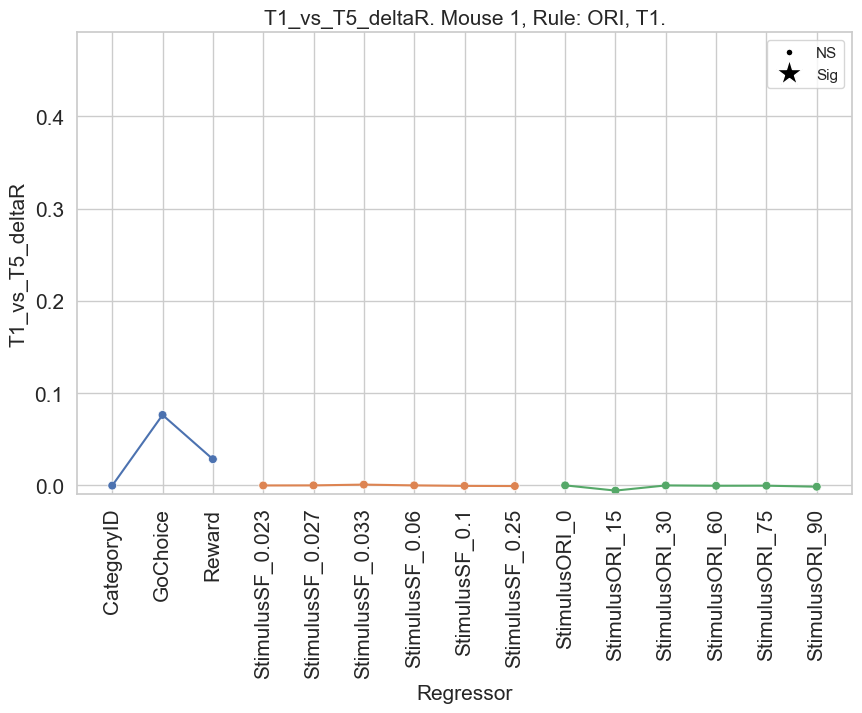

0.04405839117517263


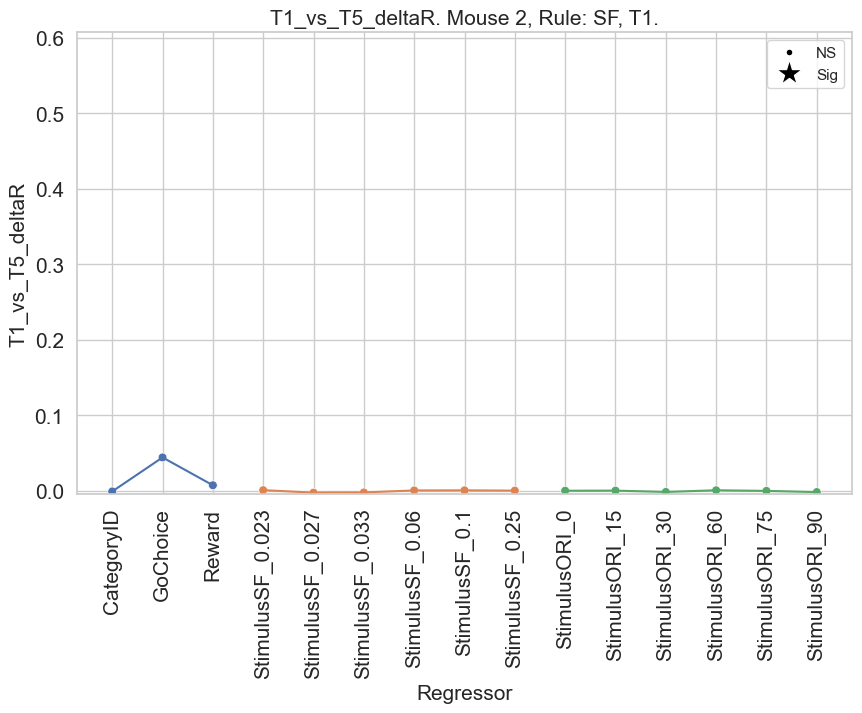

0.00799724407485597


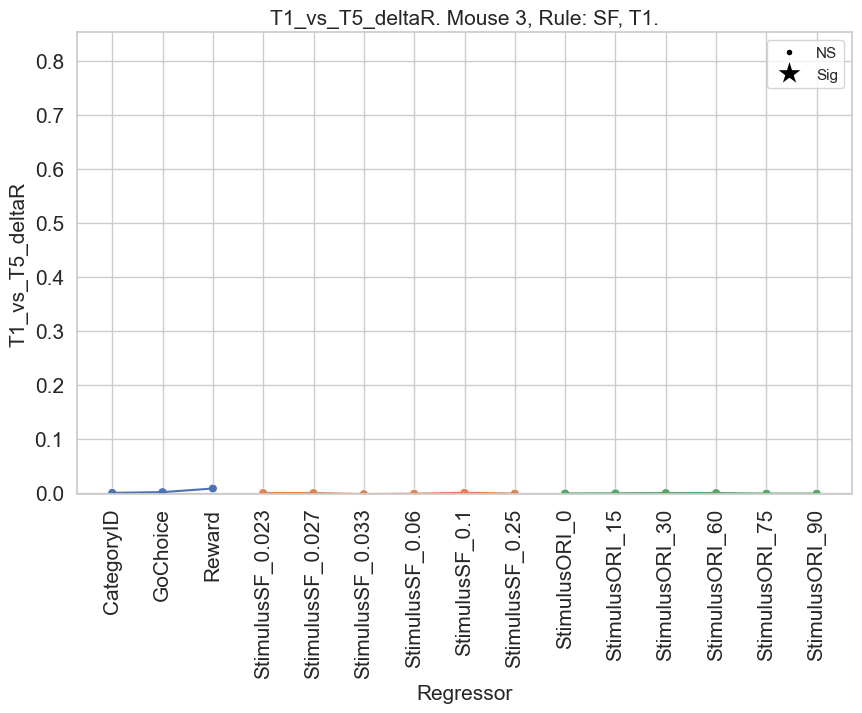

0.0021820399208089536


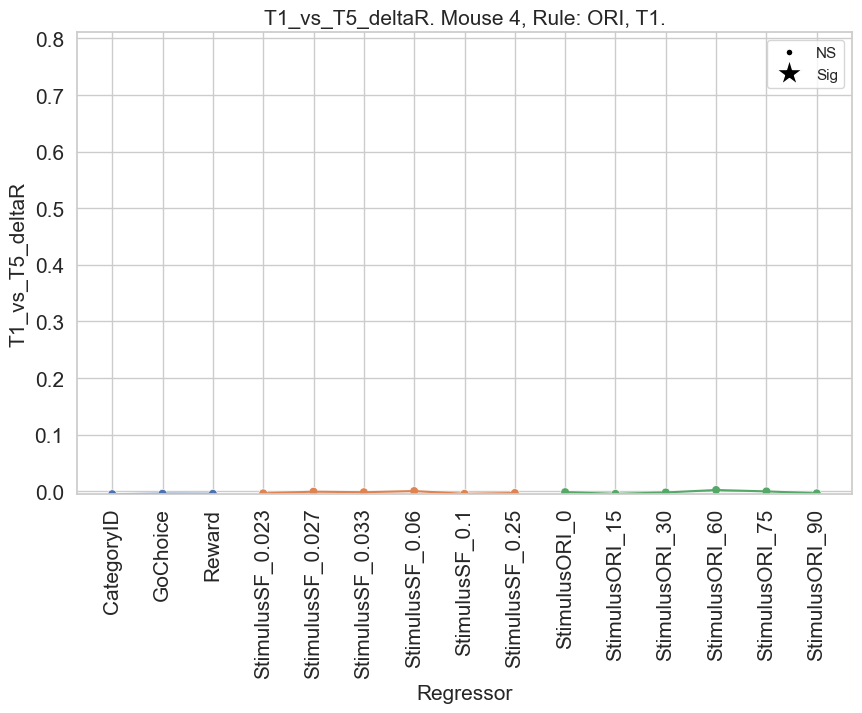

0.03587688781138676


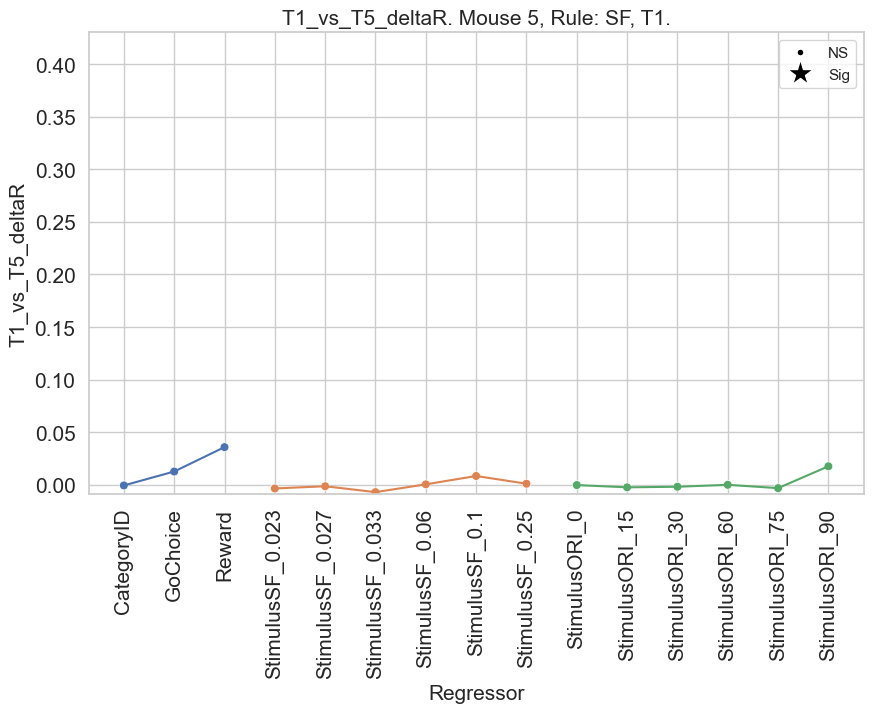

0.013456371356959512


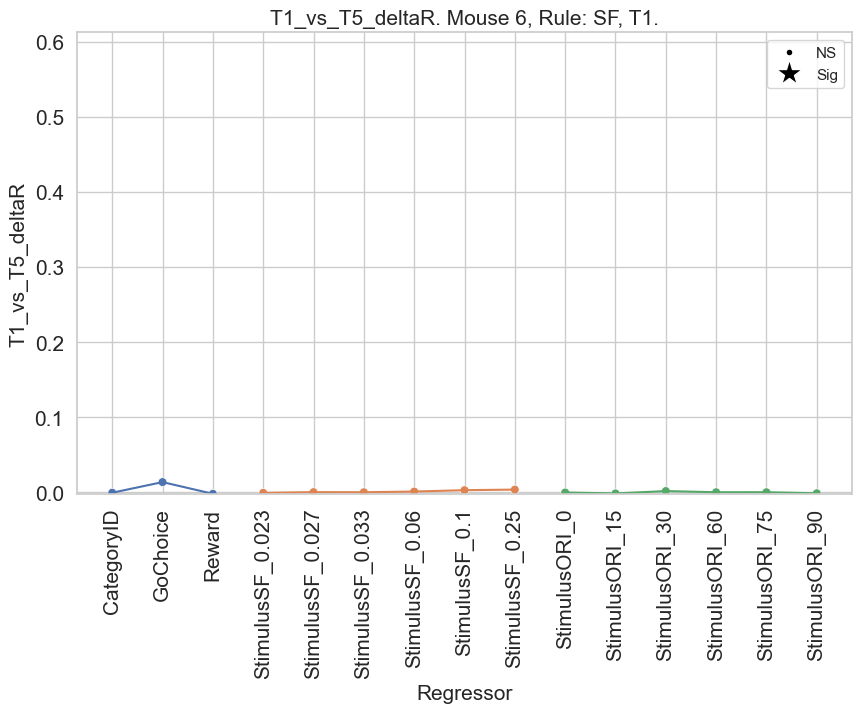

0.043683762764931675


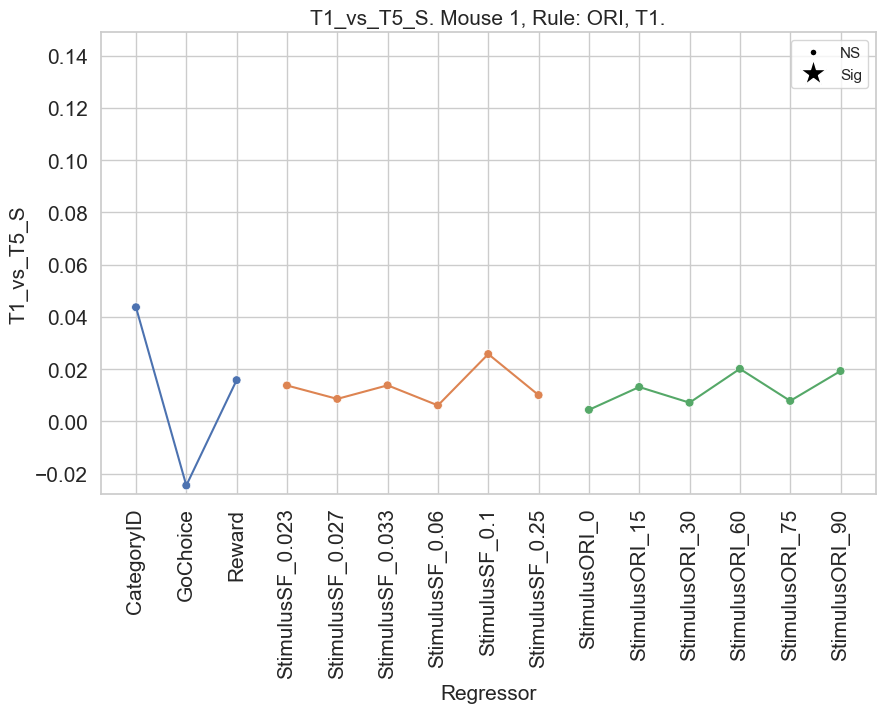

0.1234118299768398


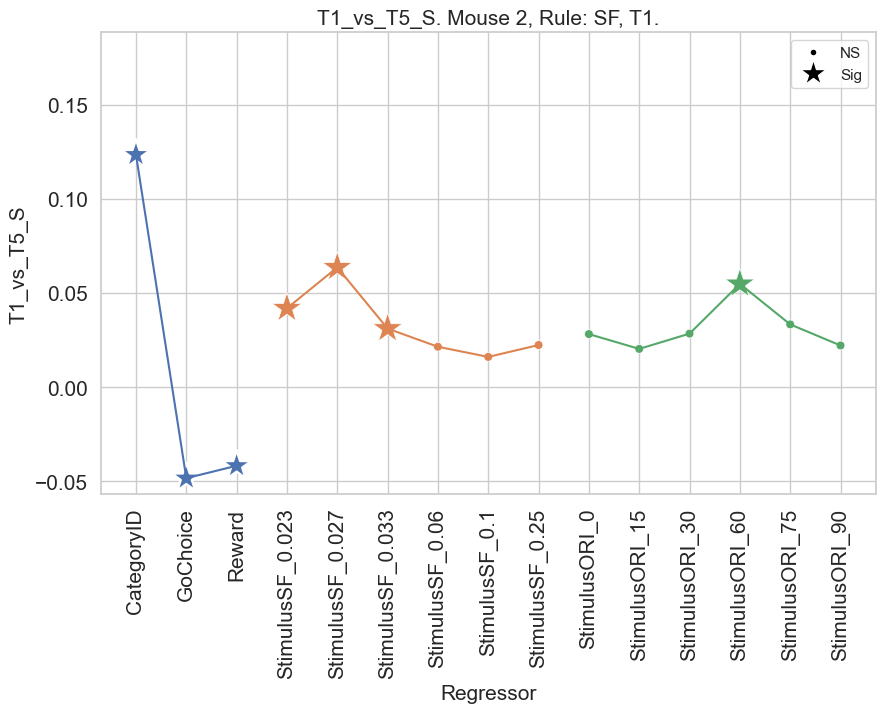

0.1394878942978968


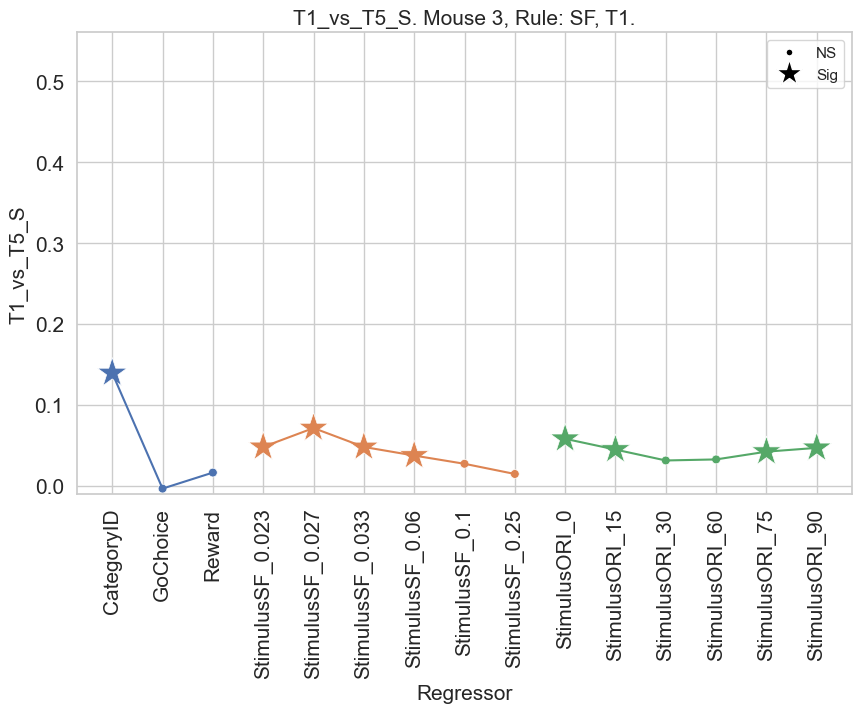

0.22500246156953457


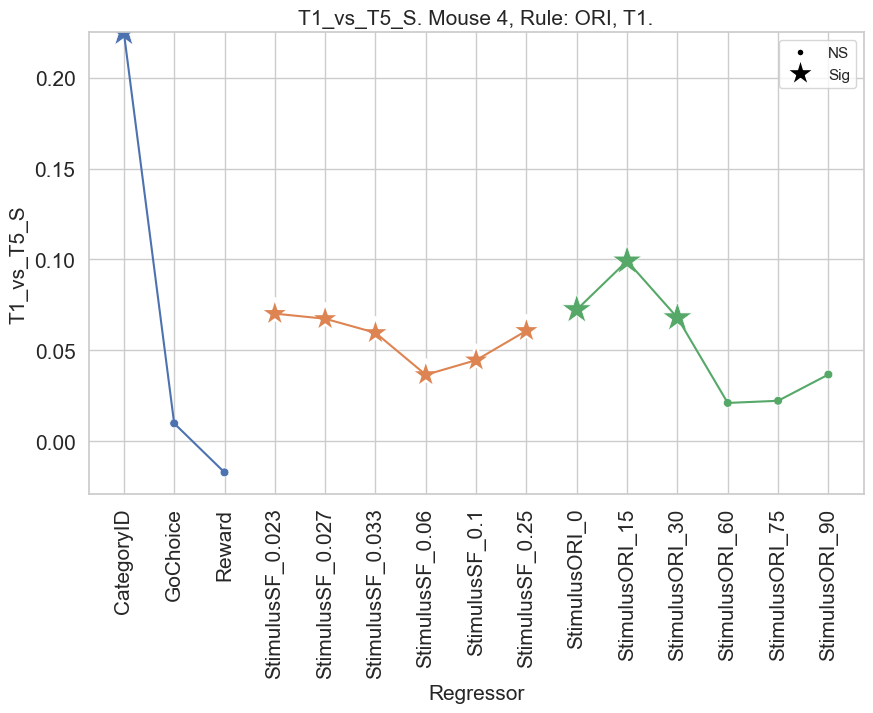

0.07704739411779381


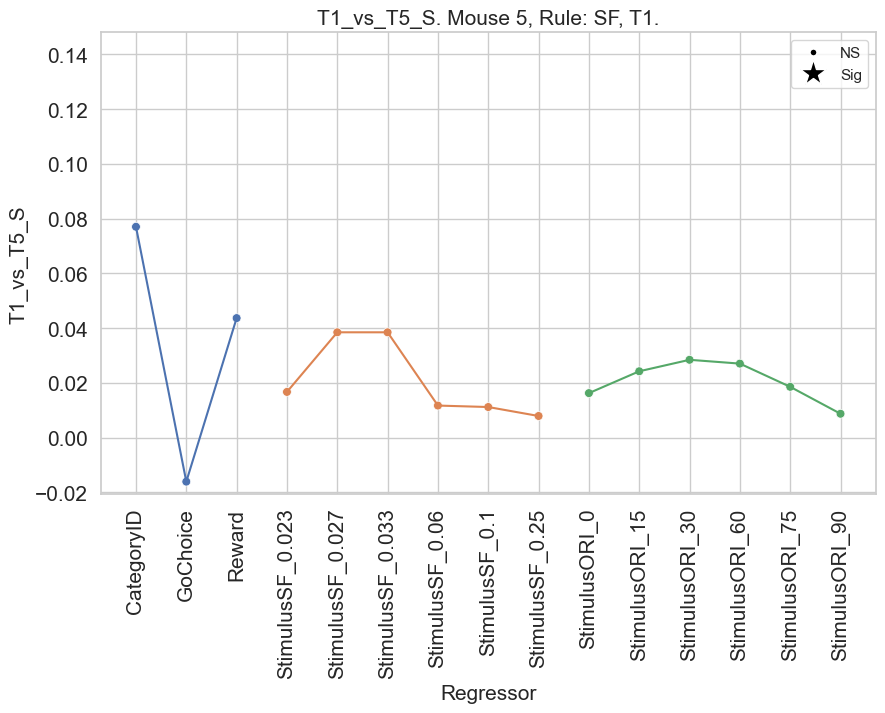

0.12445938516575039


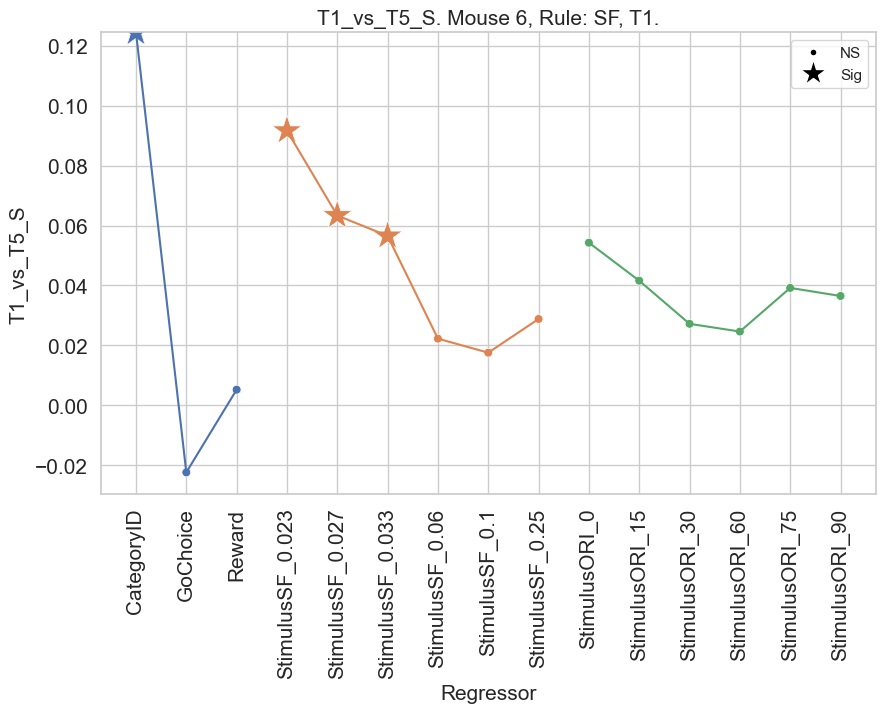

<Figure size 1000x600 with 0 Axes>

In [216]:
for index, mouse in enumerate(mice):
    ymax = max(pd.read_csv(os.getcwd() + "/b2b/csv/T5/b2b_mice1_6/deltaR_mouse_%s_rule_%s_T5.csv" %(mouse, rules[str(mouse)]))["deltaR"])
    plot_b2b_result(cross_deltaR_mice1_6_T1[index], "T1_vs_T5_deltaR", mouse, rule = rules[str(mouse)], stats = True, session = "T1", save = True, ymax = ymax, file_dir = os.getcwd() + "/b2b/figures/cross_T1/fdr_corrected/b2b_mice1_6/FDR_")
for index, mouse in enumerate(mice):
    ymax = max(pd.read_csv(os.getcwd() + "/b2b/csv/T5/b2b_mice1_6/S_mouse_%s_rule_%s_T5.csv" %(mouse, rules[str(mouse)]))["S"])
    plot_b2b_result(cross_S_mice1_6_T1[index], "T1_vs_T5_S", mouse, rule = rules[str(mouse)], stats = True, session = "T1", save = True, ymax = ymax, file_dir = os.getcwd() + "/b2b/figures/cross_T1/fdr_corrected/b2b_mice1_6/FDR_")

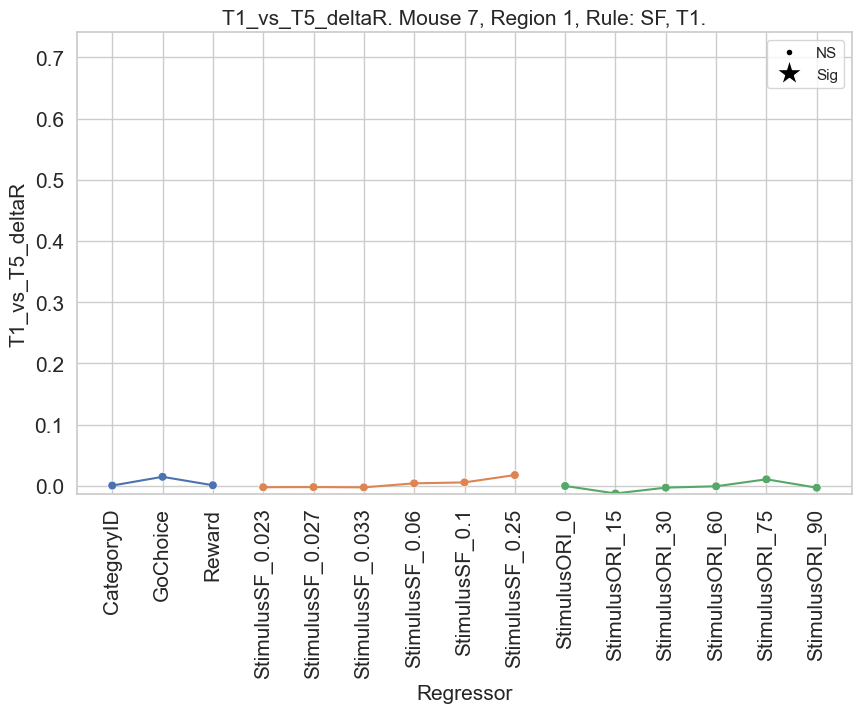

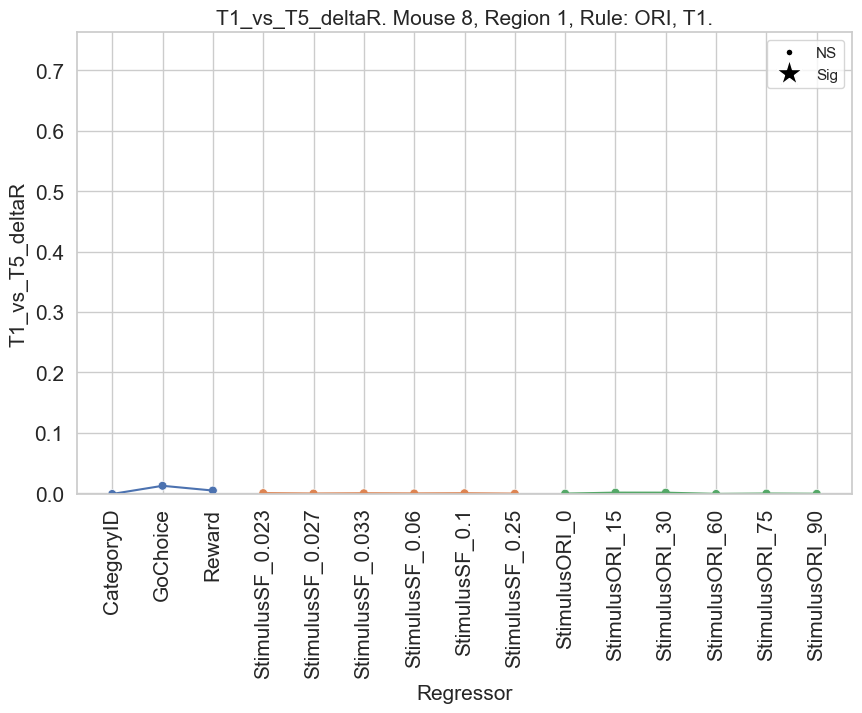

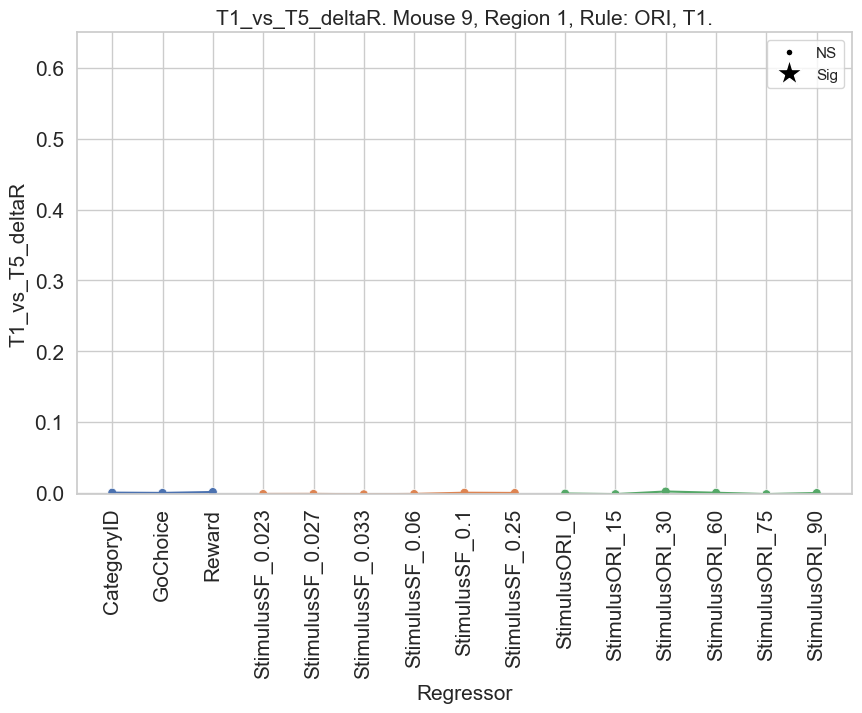

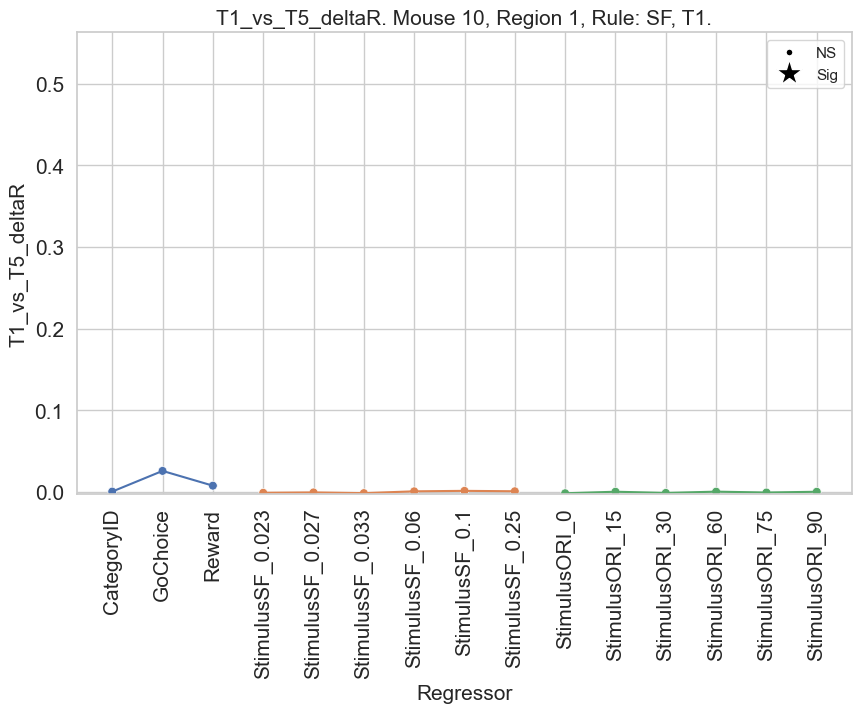

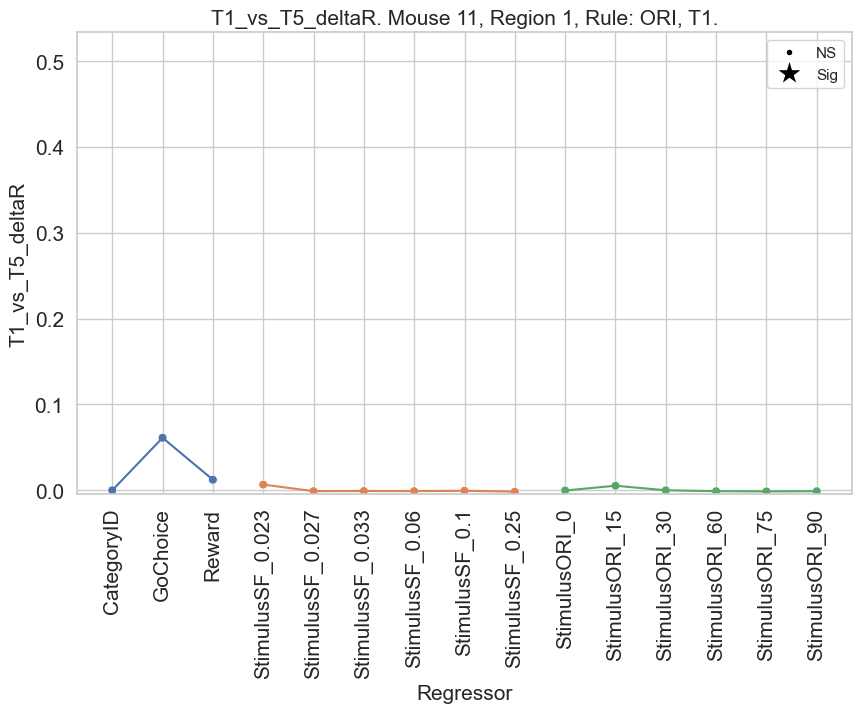

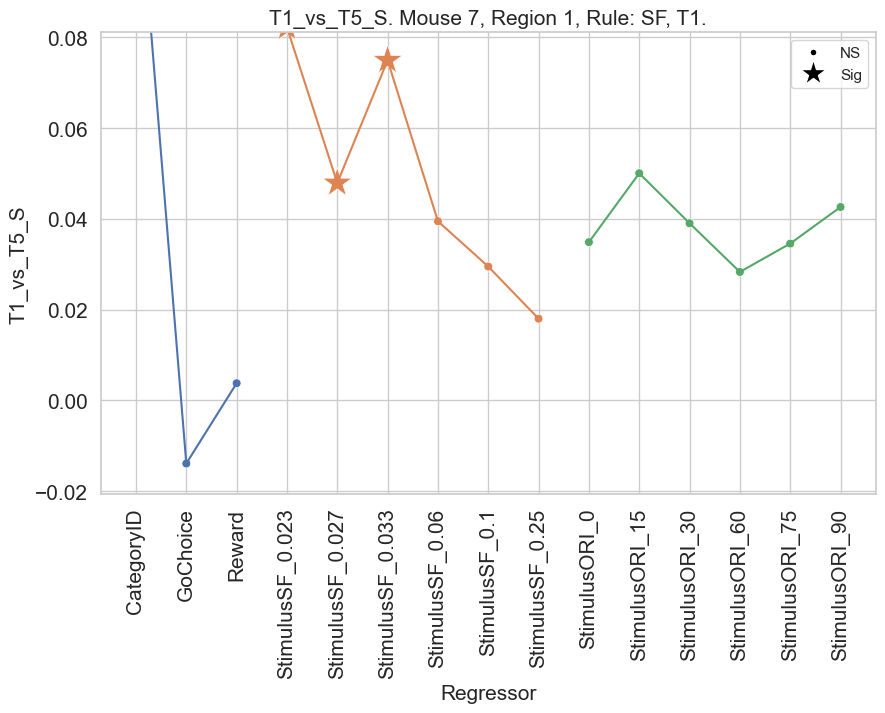

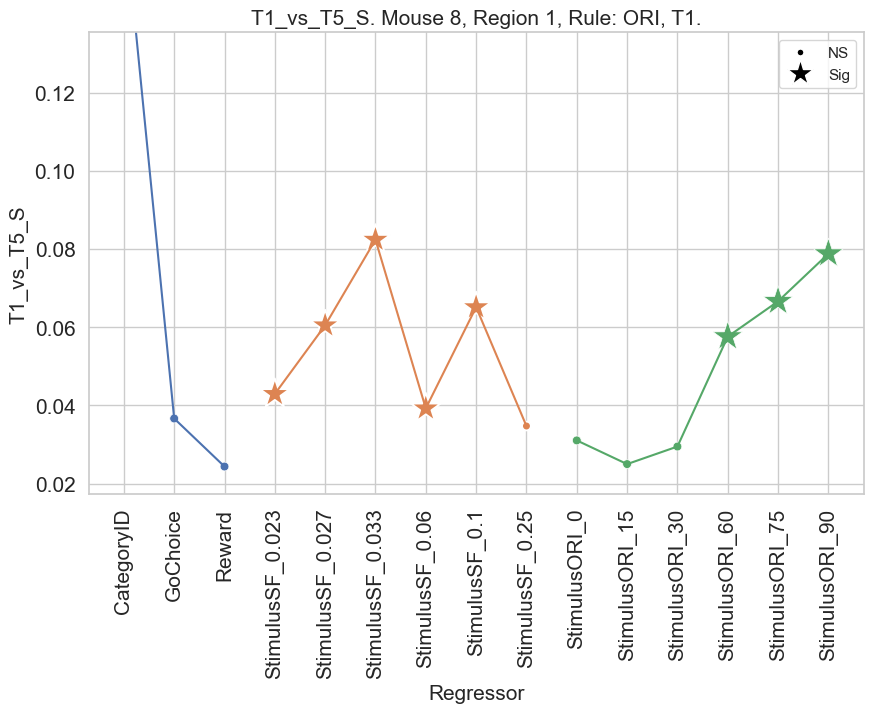

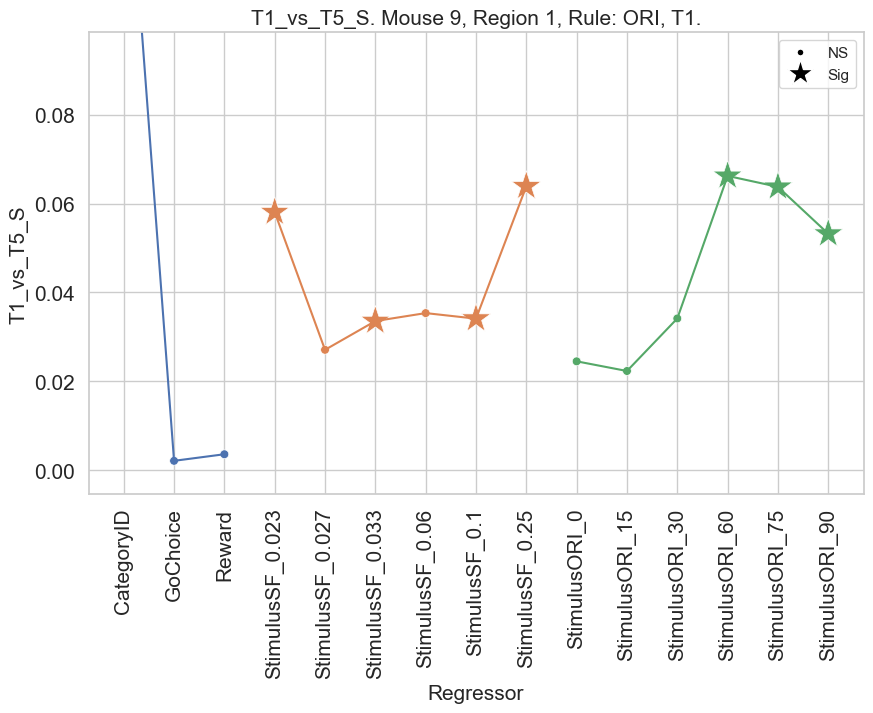

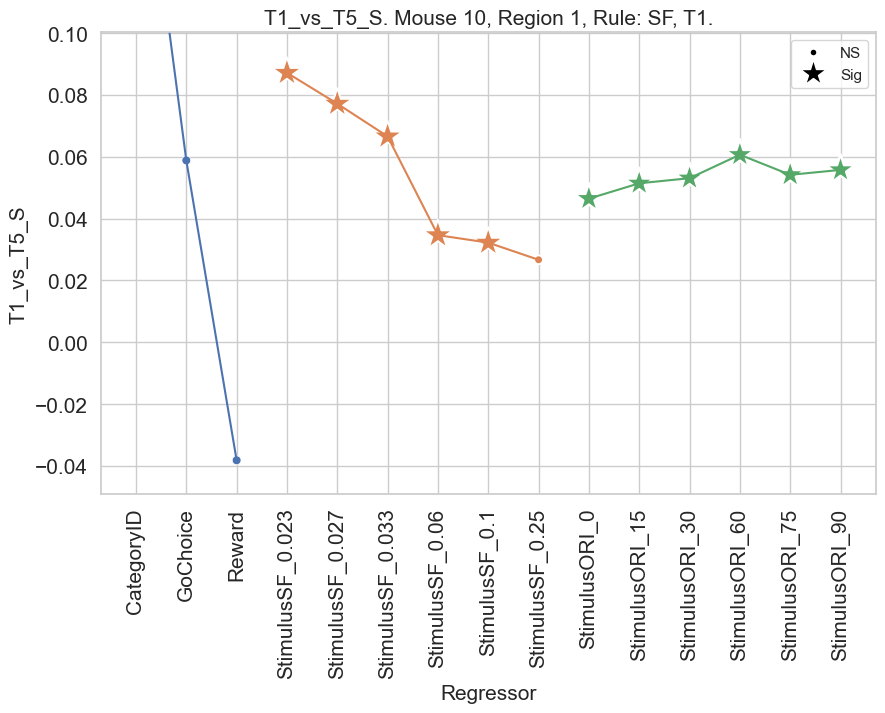

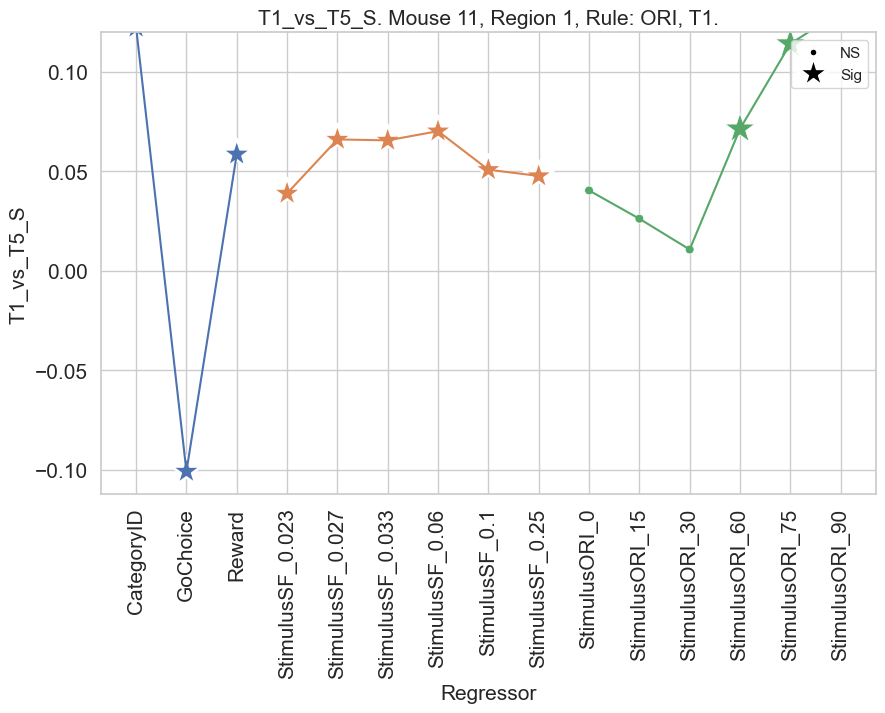

<Figure size 1000x600 with 0 Axes>

In [224]:
for index, mouse in enumerate(mice_regions):
    ymax = max(pd.read_csv(os.getcwd() + "/b2b/csv/T5/b2b_mice7_11_region1/deltaR_mouse_%s_rule_%s_T5.csv" %(mouse, rules_region[str(mouse)]))["deltaR"])
    plot_b2b_result(cross_deltaR_mice7_11_region1_T1[index], "T1_vs_T5_deltaR", mouse, rule = rules_region[str(mouse)], region = 1, stats = True, session = "T1", save = True, ymax = ymax, file_dir = os.getcwd() + "/b2b/figures/cross_T1/fdr_corrected/b2b_mice7_11_region1/FDR_")

for index, mouse in enumerate(mice_regions):
    ymax = max(pd.read_csv(os.getcwd() + "/b2b/csv/T5/b2b_mice7_11_region1/S_mouse_%s_rule_%s_T5.csv" %(mouse, rules_region[str(mouse)]))["S"])
    plot_b2b_result(cross_S_mice7_11_region1_T1[index], "T1_vs_T5_S", mouse, rule = rules_region[str(mouse)], stats = True, region = 1, session = "T1", save = True, ymax = ymax, file_dir = os.getcwd() + "/b2b/figures/cross_T1/fdr_corrected/b2b_mice7_11_region1/FDR_")

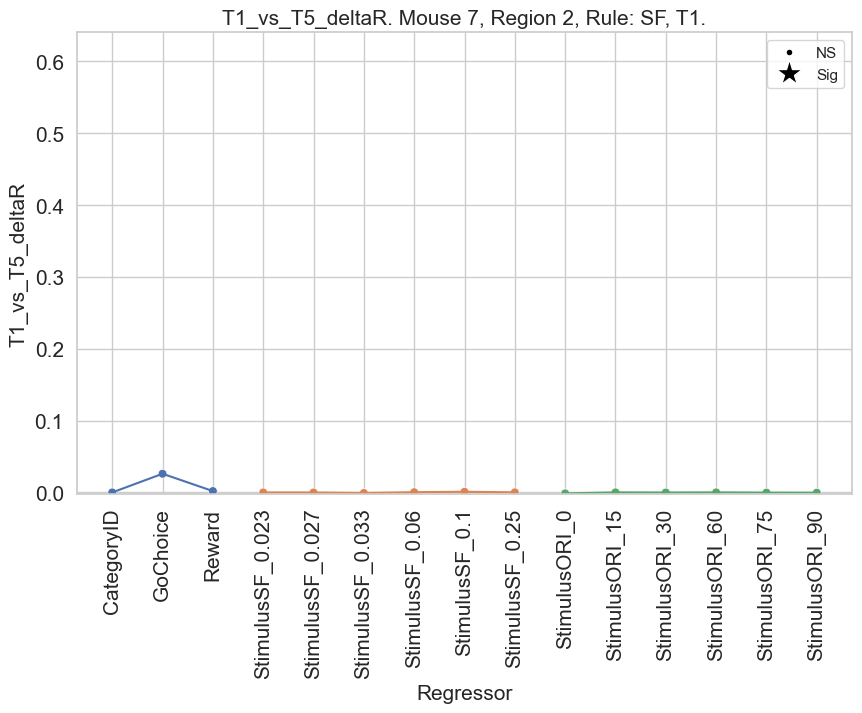

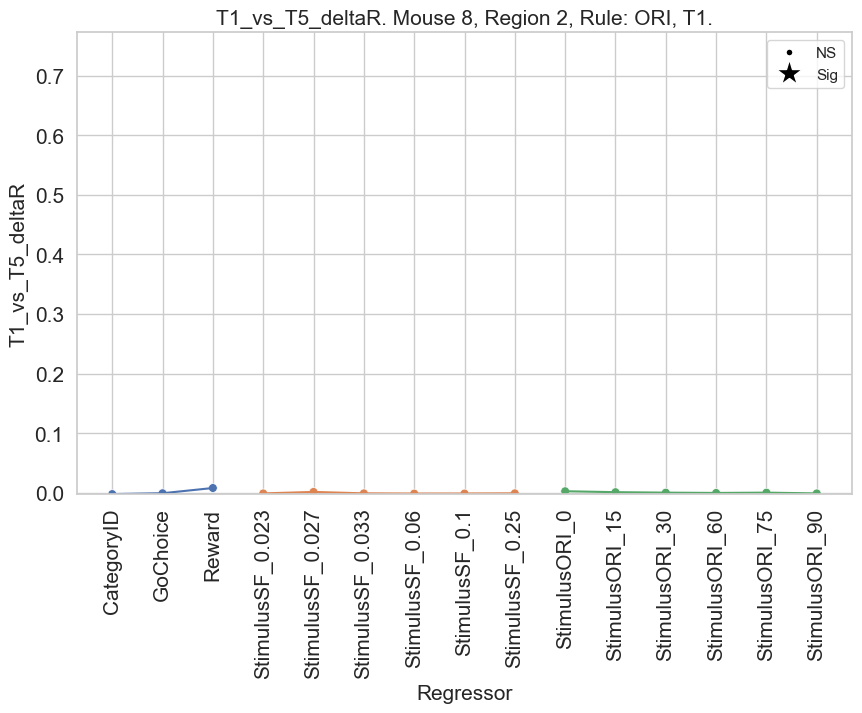

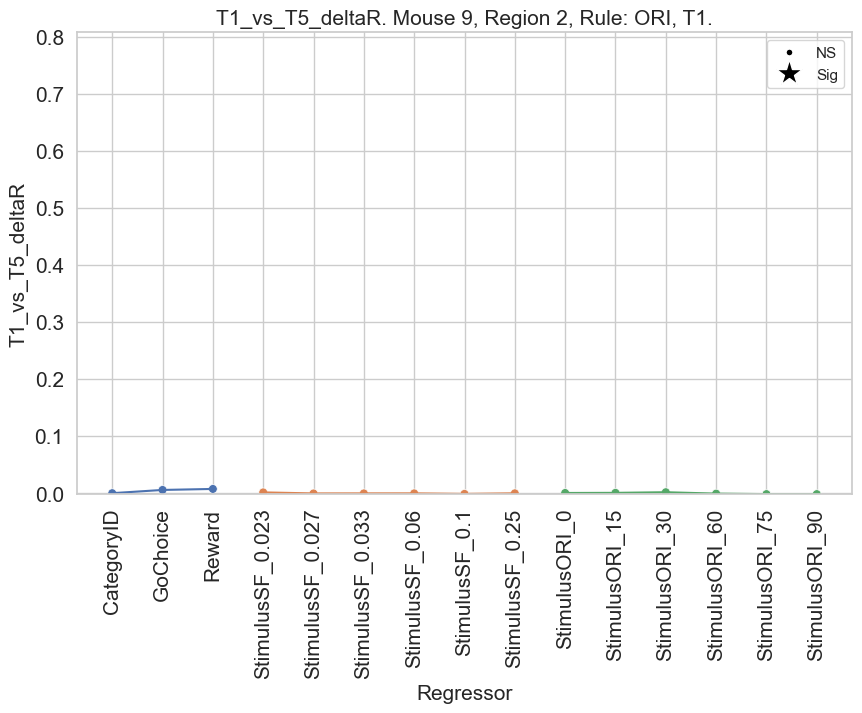

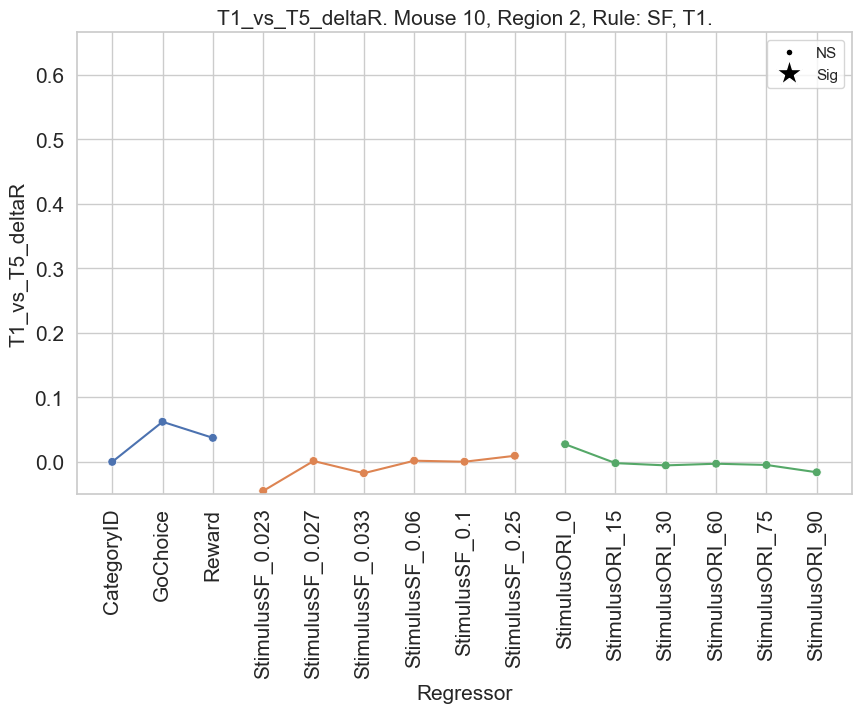

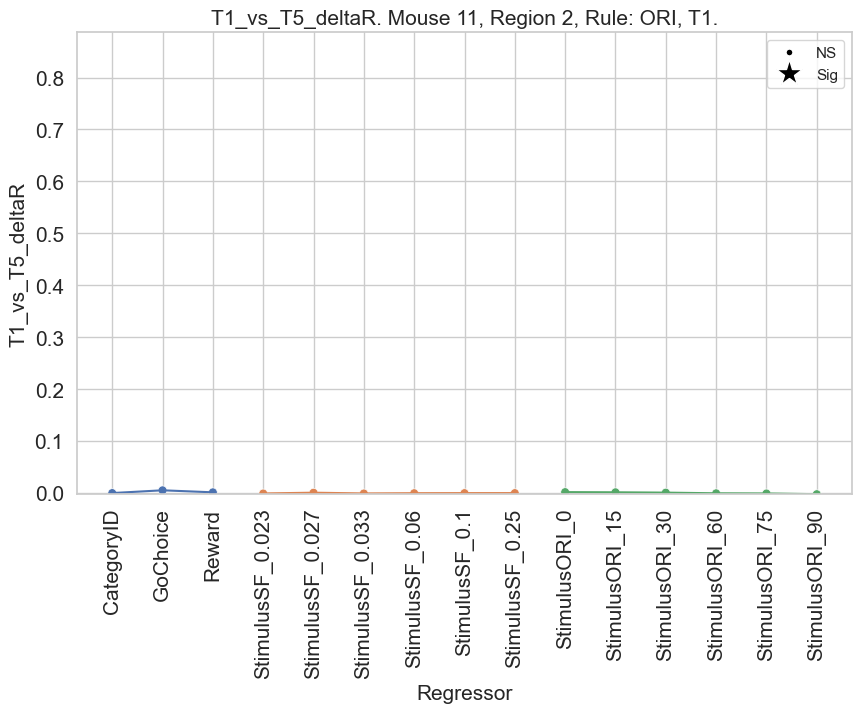

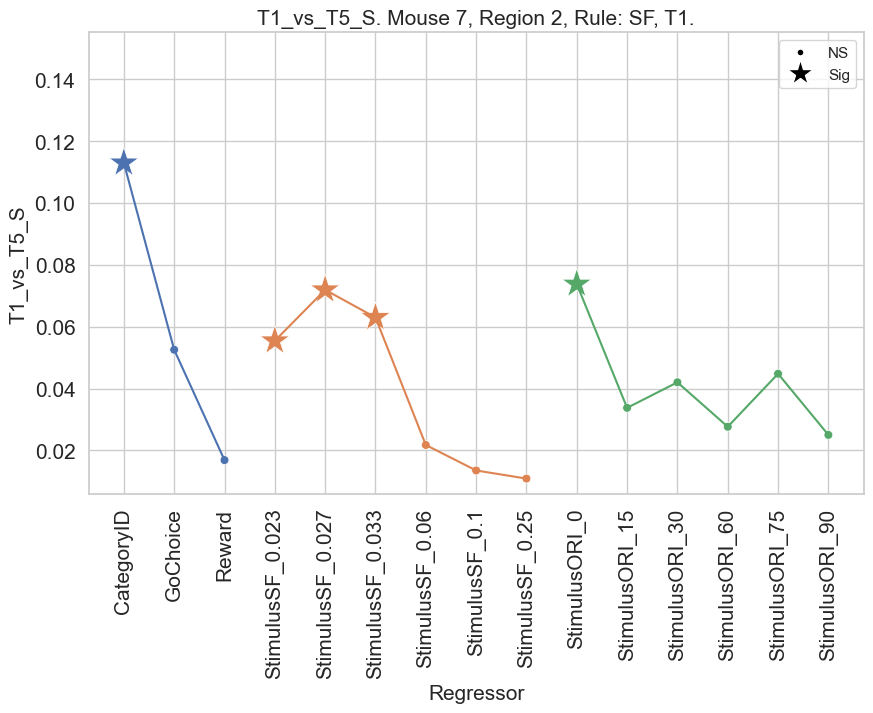

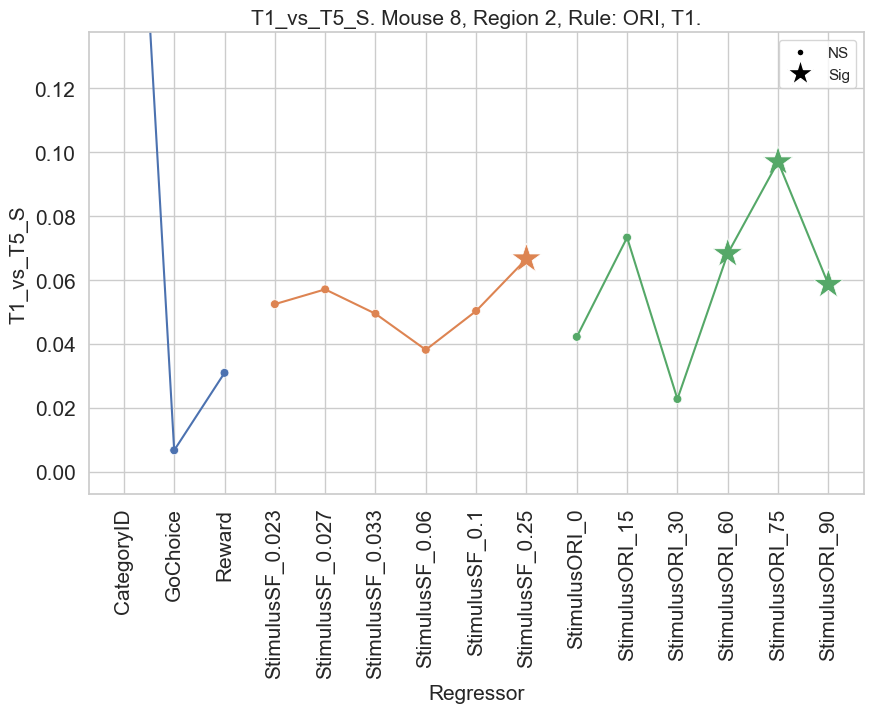

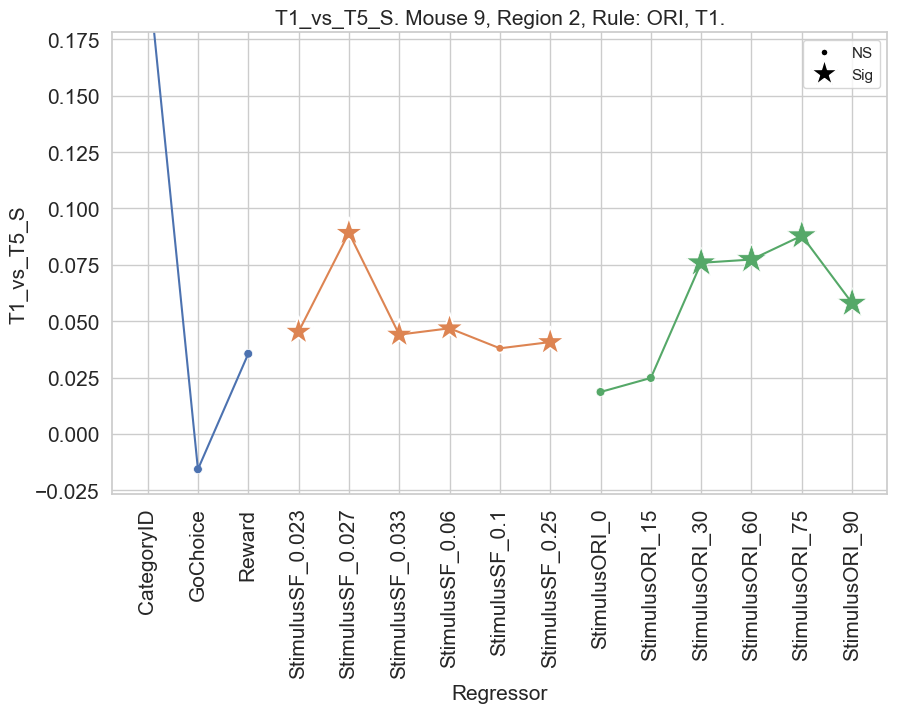

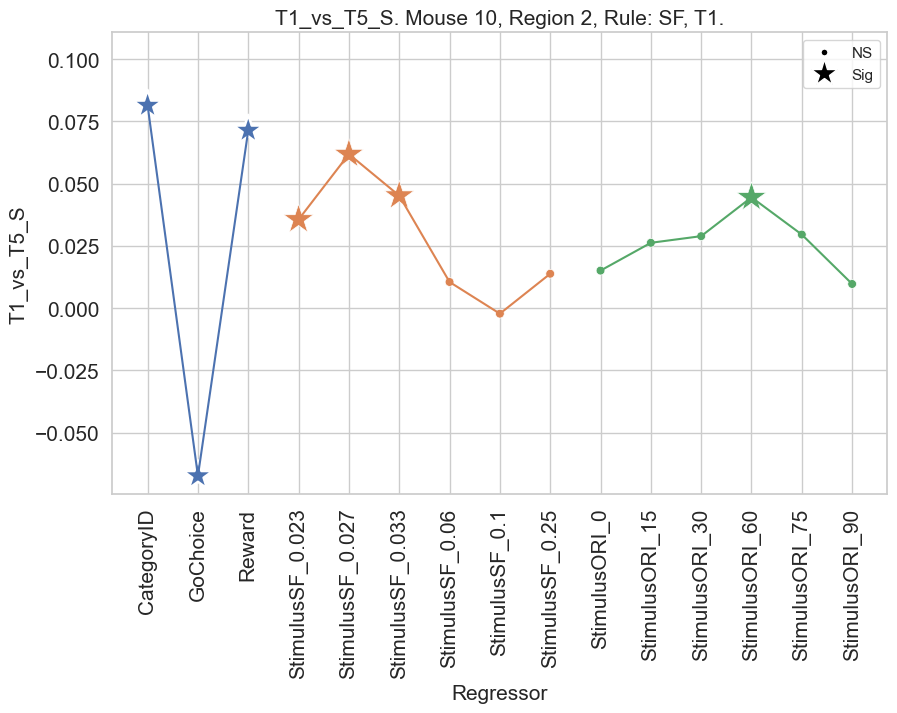

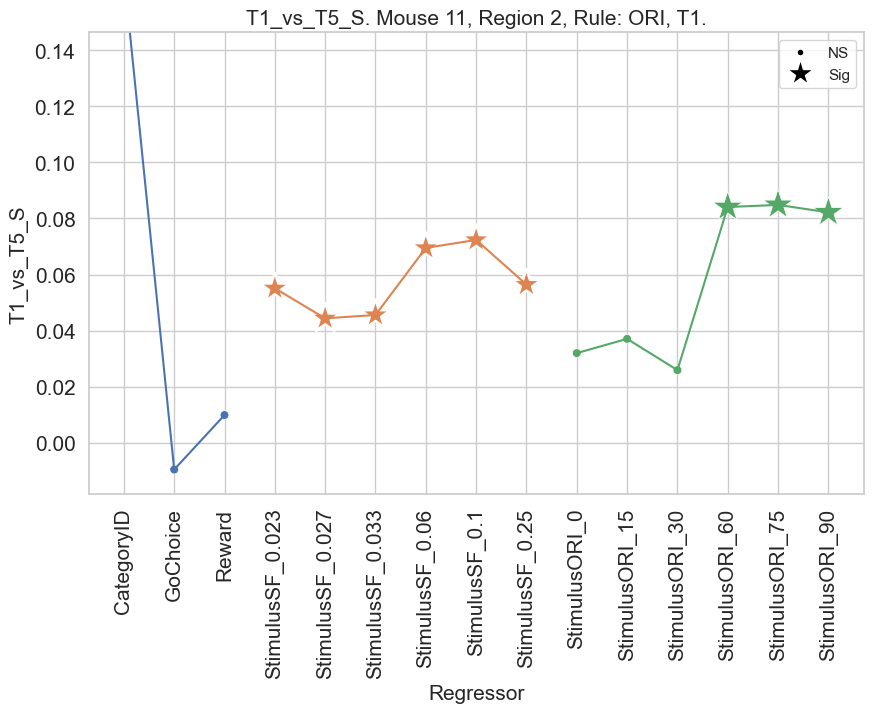

<Figure size 1000x600 with 0 Axes>

In [225]:
for index, mouse in enumerate(mice_regions):
    ymax = max(pd.read_csv(os.getcwd() + "/b2b/csv/T5/b2b_mice7_11_region2/deltaR_mouse_%s_rule_%s_T5.csv" %(mouse, rules_region[str(mouse)]))["deltaR"])
    plot_b2b_result(cross_deltaR_mice7_11_region2_T1[index], "T1_vs_T5_deltaR", mouse, rule = rules_region[str(mouse)], stats = True, session = "T1", save = True, region = 2, ymax = ymax, file_dir = os.getcwd() + "/b2b/figures/cross_T1/fdr_corrected/b2b_mice7_11_region2/FDR_")

for index, mouse in enumerate(mice_regions):
    ymax = max(pd.read_csv(os.getcwd() + "/b2b/csv/T5/b2b_mice7_11_region2/S_mouse_%s_rule_%s_T5.csv" %(mouse, rules_region[str(mouse)]))["S"])
    plot_b2b_result(cross_S_mice7_11_region2_T1[index], "T1_vs_T5_S", mouse, rule = rules_region[str(mouse)], stats = True, session = "T1", save = True, region = 2, ymax = ymax, file_dir = os.getcwd() + "/b2b/figures/cross_T1/fdr_corrected/b2b_mice7_11_region2/FDR_")